## Computer Vision

In `Computer Vision` Problems we want to train a Neural Network to identify patterns in complex images and classified them into a category.

As we saw, this problem we be solved using just **Linear Layers** and **Activation Functions**, but the accuracy of this type of models is relatively small.

To increase the metrics of our model we use a `Convolutional Neuarl Network`.

Other to solve Classification problems we can use Computer Vision (or CNNs) for **image segmentation**, meaning to find the different objects that eixsts on an image.

How do we handle _computer vison_ problems?

Just like any other problem:
1. Creating/Downloading the Dataset
2. Converting the Dataset into Tensors
3. Splitting the Dataset into Training and Test Sets
4. Creating the Model
5. Training and Evaluating the Model

## Importing the Modules we will Need

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor   # Converting PIL Image or numpy array into a Tensor
from torchvision.datasets import FashionMNIST # The Dataset we will use (grayscale images of clothes)

import matplotlib.pyplot as plt
import pandas as pd

from timeit  import default_timer as timer    # To track the time our model took to train
from tqdm.auto import tqdm                    # To create a progress bar

In [2]:
!pip install torchmetrics
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
from torchmetrics import ConfusionMatrix            # For further evaluation
from mlxtend.plotting import plot_confusion_matrix  # For plotting the confusion metrix

## Downloading the Dataset

In [4]:
train_dataset = FashionMNIST(root="/Datasets", download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root="/Datasets", download=True, train=False, transform=ToTensor())

print(train_dataset)
print(test_dataset)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /Datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /Datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /Datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /Datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Datasets/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


## Understanding the Dataset

### Visualizing The Dataset as Numbers

In [5]:
image, label = train_dataset[0]

print(image.shape, label, type(label)) # The shape is (Colour Channels, Height, Width)
print(image[0][0][:5])                 # We see that it is actual a gray scale image

torch.Size([1, 28, 28]) 9 <class 'int'>
tensor([0., 0., 0., 0., 0.])


In [ ]:
# We can get some informations about the labels of this dataset
name_classes = train_dataset.classes

print(type(name_classes), name_classes)

<class 'list'> ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# So the above sample of the dataset is:
print(name_classes[label])

Ankle boot


### Visualizing the Dataset as Images

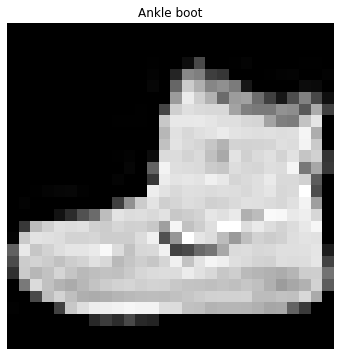

In [ ]:
image, label = train_dataset[0]

plt.figure(figsize=(6, 6))
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"{train_dataset.classes[label]}")
plt.axis(False);

# We need 'squeeze()' because plt does not support colour channels in a gray scale image

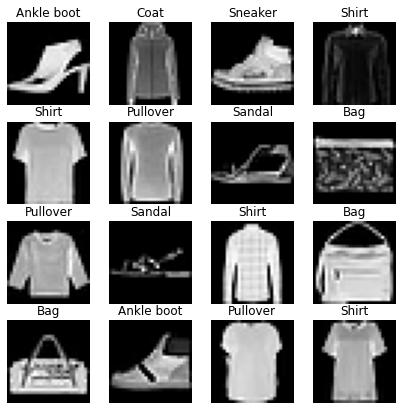

In [ ]:
# Plotting more than one sample
def image_grid(samples):
    fig = plt.figure(figsize=(7, 7))
    rows, cols = samples, samples
    for i in range(1, rows*cols + 1):
        random_i = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[random_i]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"{train_dataset.classes[label]}")
        plt.axis(False);

image_grid(4)

## Preparing the DataLoader

Now, the Dataset has the type of **FashionMNIST** Dataset. We want to convert this dataset into a Python _iterator_.

For that we are going to use `DataLoader`.

Each set of samples that this _iterator_ returns also called **Batches**.

We split the Dataset into **Batches** due to limited memory. In large Datasets with millions of millions samples, the Dataset might not be able to be stored on a machine, so each time we are storing only a number of its samples.

The second reason we want to split the Dataset into **Batches** is to give the model more chances to update its parameters pre epoch. That is a conclusion from the fact that the model only update its weights and biases when it has seen all the training dataset.

In [ ]:
train_dl = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) # Where batch_size is the number of samples per batch
test_dl = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print(len(train_dl), len(test_dl))

1875 313


In [ ]:
# Visualize the DataLoader Objects
train_features, train_labels = next(iter(train_dl))

print(train_features.shape) # Where as first dimension is 'batch_size'
print(train_labels, train_labels.shape)

torch.Size([32, 1, 28, 28])
tensor([9, 4, 6, 4, 3, 4, 4, 5, 3, 4, 6, 1, 2, 3, 0, 8, 7, 7, 3, 2, 9, 2, 5, 5,
        9, 8, 1, 8, 2, 2, 3, 9]) torch.Size([32])


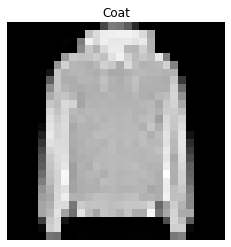

In [ ]:
# Visualize a sample of the first batch
image, label = train_features[9], train_labels[9]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"{name_classes[label]}")
plt.axis(False);

## Creating the Baseline Model

Base on that Model we are going to create more powerfull models, by adding complexity to it.

### Introduce the `nn.Flatten()` layer.

This Layer is used to connect a _Convolutional_ and a _Linear_ layer. 

In [ ]:
flatten_model = nn.Flatten() # Initializing the Flatten Object

# This layer just flatten the tensors that gets as an input
features = train_features[0]
print(features.shape) # [Colour Channels, Height, Width]

flatten_features = flatten_model (features)
print(flatten_features.shape) # [Colour Channels, Height*Width]

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [ ]:
# 0. Linear with no Activation Model
class FashionMNIST_ModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

### Initializing the Baseline Model

In [ ]:
modelv0 = FashionMNIST_ModelV0(28*28, 64, len(name_classes))

print(modelv0)

FashionMNIST_ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Understanding the Logits of the Model

In [ ]:
## Creating a dummy input:
dummy_input = torch.randn(size=(1, 1, 28, 28))

modelv0.eval()
with torch.inference_mode():
    logits = modelv0(dummy_input)

print(logits)

tensor([[-0.5546, -0.1759, -0.6263,  0.1378,  0.0048, -0.7362, -0.3052, -0.4323,
         -0.2305, -0.3331]])


In [ ]:
# Converting those logits into labels
probs = torch.softmax(logits, dim=1)
print(probs)

labels = torch.softmax(logits, dim=1).argmax(dim=1)
print(labels)

tensor([[0.0768, 0.1122, 0.0715, 0.1535, 0.1344, 0.0641, 0.0986, 0.0868, 0.1062,
         0.0959]])
tensor([3])


## Creating the Training and Evaluating Loop

In [ ]:
def fit(model, epochs, train_dl, test_dl, loss_fn, accuracy_fn, optimizer):
    losses, accs = [], []
    start_time = timer()

    # With device.type we can access the name of a pytorch device    
    train_device = "cuda" if next(model.parameters()).device.type == torch.device("cuda").type else "cpu"

    print("Starting Process:")

    for epoch in tqdm(range(1, epochs + 1)):
        # Iterate over the batches of the training data loader
        for batch, (x_train, y_train) in enumerate(train_dl, start=1):

            # Moving batches to device
            x_train, y_train = x_train.to(torch.device(train_device)), y_train.to(torch.device(train_device))

            model.train()
            
            train_logits = model(x_train)
            train_loss = loss_fn(train_logits, y_train)

            optimizer.zero_grad()
            train_loss.backward() # Backpropagation
            optimizer.step()      # Gradient Descent

            if batch % (int(len(train_dl) / 4)) == 0:
                print(f"\tLooked at: {batch*len(x_train)}/{len(train_dl)*len(x_train)} training bathces.")

        # Initizlizing the batch evaluating variables
        batch_loss, batch_acc = 0, 0

        model.eval()
        with torch.inference_mode():
            # Iterate over the batches of the test data loader
            for x_test, y_test in test_dl:

                # Moving batches to device
                x_test, y_test = x_test.to(torch.device(train_device)), y_test.to(torch.device(train_device))

                test_logits = model(x_test)
                
                # Calclating the Metrics
                batch_loss += loss_fn(test_logits, y_test)
                batch_acc += accuracy_fn(torch.softmax(test_logits, dim=1).argmax(dim=1), y_test)
            
            batch_loss /= len(test_dl)
            batch_acc /= len(test_dl)

            losses.append(batch_loss)
            accs.append(batch_acc)

        print(f"-> Epoch: {epoch} | Loss: {batch_loss:.4f} | Acc: {batch_acc*100:.2f}%")

    return losses, accs, {"model_name": model.__class__.__name__,
                          "model_loss": batch_loss.item(),
                          "model_acc(%)": batch_acc,
                          "model_device": train_device,
                          "model_time": timer() - start_time}

## Setting up Loss Function, Evaluation Metric and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.SGD(modelv0.parameters(), lr = 0.1)

In [ ]:
def accuracy_fn(preds, labels):
    return torch.sum(preds == labels).item() / len(labels)

## Training the Model

In [ ]:
loss1, acc1, results1 = fit(modelv0, 5, train_dl, test_dl, loss_fn, accuracy_fn, optimizer)

Starting Process:


  0%|          | 0/5 [00:00<?, ?it/s]

	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 1 | Loss: 0.5238 | Acc: 81.29%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 2 | Loss: 0.4747 | Acc: 83.36%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 3 | Loss: 0.4910 | Acc: 83.02%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 4 | Loss: 0.4711 | Acc: 83.60%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathc

## Caclulating Baseline Model Results 

In [ ]:
print(results1)

{'model_name': 'FashionMNIST_ModelV0', 'model_loss': 0.46997973322868347, 'model_acc(%)': 0.8333666134185304, 'model_device': 'cpu', 'model_time': 65.11041171700003}


## Improve the Baseline Model

### 1) Train on GPU

#### Setting up Device Agnostic Code

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


#### Creating a Model that uses non-linearities and is trained on GPU

In [ ]:
class FashionMNIST_ModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

#### Initialize the New Modelk

In [ ]:
modelv1 = FashionMNIST_ModelV1(28*28, 64, len(name_classes)).to(device)

print(modelv1)

FashionMNIST_ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


#### Setting up Loss Functionand Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.SGD(modelv1.parameters(), lr=0.1)

#### Training the Model

In [ ]:
loss2, acc2, res2 = fit(modelv1, 5, train_dl, test_dl, loss_fn, accuracy_fn, optimizer)

Starting Process:


  0%|          | 0/5 [00:00<?, ?it/s]

	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 1 | Loss: 0.4929 | Acc: 82.14%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 2 | Loss: 0.4224 | Acc: 85.26%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 3 | Loss: 0.3787 | Acc: 86.32%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 4 | Loss: 0.3912 | Acc: 85.30%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathc

#### Calculating Models Results

In [ ]:
print(res2)

{'model_name': 'FashionMNIST_ModelV1', 'model_loss': 0.35536879301071167, 'model_acc(%)': 0.8685103833865815, 'model_device': 'cpu', 'model_time': 59.53891304199999}


We can notice a slightly decrease in the training time of the two models. Thats due to the relatively small dataset and the small shape of the features. As we adding more layers to the model, this difference is going to increase as well.

### 2) Using CNN and GPU

#### Understanding Convolution

Takes as an argument a batch of data.

In [ ]:
# Creating some dummy data (with 3 colour channels and 64x64 bits height and width)
dummy_batch = torch.rand(size=(32, 3, 64, 64))

print(dummy_batch.shape)

torch.Size([32, 3, 64, 64])


In [ ]:
# Creating a Convolutional Layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=1) 

# `in_channels` : The colour channels
# `out_channels`: The hidden units
# `kernel_size` : The size of the kernel (modifying the dimensions of the image)
# `stride`      : The hoveore of the kernel (decrease the dimensions of the image)
# `padding`     : The extra pixels around the edge of the image (modifying the dimensions of the image)

In [ ]:
# Passing the data through the layer
conv_output = conv_layer(dummy_batch)

print(conv_output.shape)

torch.Size([32, 10, 64, 64])


In [ ]:
# Now we will go through a ReLU Layer
relu = nn.ReLU()

relu_output = relu(conv_output)

print(relu_output.shape)

torch.Size([32, 10, 64, 64])


In [ ]:
# And through a Max Pool Layer (with `MaxPool` we are getting the most important pixel of an area)
max_pool = nn.MaxPool2d(kernel_size=(2, 2))

max_pool_output = max_pool(relu_output)

print(max_pool_output.shape)

# Notice that this output shape is half the original shape
# `padding = 0` reduce the shape by 2
# `stride = 2` reduce the shape by half

torch.Size([32, 10, 32, 32])


#### Working with smaller Tensors to Visualize

In [ ]:
dummy_2 = torch.randn(size=(1, 1, 2, 2)) # size=(Batch Size, Colour Channels, Height, Width)

print(dummy_2)

tensor([[[[-0.4577, -1.7123],
          [ 2.0496,  1.2044]]]])


In [ ]:
relu_d = relu(dummy_2)

print(relu_d)

tensor([[[[0.0000, 0.0000],
          [2.0496, 1.2044]]]])


In [ ]:
max_d = max_pool(relu_d)

print(max_d)

tensor([[[[2.0496]]]])


#### Creating the Model

In [ ]:
class FashionMNIST_ModelV2(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()

        # A Convolutional Block contains a Conv, Non_Linear, Conv, Non-Linear and Pooling Layers
        # A Deep-CNN contains a number of Convolutional Blocks
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,    # Is the colour channels
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Creating a second Convolutional Block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Creating a Linear Layer for the output
        self.classifier = nn.Sequential(
            nn.Flatten(), # Because the ouput of the Conv Blocks is going to be a multi-dim Tensor
            nn.Linear(in_features=hidden_units*7*7, out_features=output_size)

            # Where hidden_units*7*7 is the product of the shape of the output of the last `conv_block`
        )

    def forward(self, x):
        # To troubleshoot and figure the `in_features` of the Linear Stack we can print the shapes of the output pre block
        x = self.conv_block_1(x)
        # print(f"Output Shape of conv_block_1: {x.shape}") # (1, 10, 14, 14)

        x = self.conv_block_2(x)
        # print(f"Output Shape of conv_block_2: {x.shape}") # (1, 10, 7, 7)

        x = self.classifier(x)
        # print(f"Output Shape of linear_layer: {x.shape}") # (1, 10)

        # Of course in the next NNs we are not going to keep that format inside 'forward()', but for this example I will allow it.

        return x

#### Initialize the Model

In [ ]:
modelv2 = FashionMNIST_ModelV2(1, 10, len(name_classes)).to(device)

print(modelv2)

FashionMNIST_ModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


#### Passing Dummy Data throught the Model

In [ ]:
rand_data = torch.randn(size=(1, 28, 28)).to(device) # size=(Colour Channels, Height, Width)

output = modelv2(rand_data.unsqueeze(0))

print(output, output.shape)

tensor([[ 0.0297, -0.0366,  0.0078, -0.0114,  0.0206,  0.0857, -0.0103, -0.0869,
          0.0361, -0.0088]], grad_fn=<AddmmBackward0>) torch.Size([1, 10])


#### Setting up Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.SGD(modelv2.parameters(), lr=0.1)

#### Training the Model

In [ ]:
loss3, acc3, res3 = fit(modelv2, 5, train_dl, test_dl, loss_fn, accuracy_fn, optimizer)

Starting Process:


  0%|          | 0/5 [00:00<?, ?it/s]

	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 1 | Loss: 0.4046 | Acc: 85.19%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 2 | Loss: 0.3967 | Acc: 85.50%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 3 | Loss: 0.3409 | Acc: 88.12%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathces.
-> Epoch: 4 | Loss: 0.3070 | Acc: 89.45%
	Looked at: 14976/60000 training bathces.
	Looked at: 29952/60000 training bathces.
	Looked at: 44928/60000 training bathces.
	Looked at: 59904/60000 training bathc

#### Calculating Models Results

In [ ]:
print(res3)

{'model_name': 'FashionMNIST_ModelV2', 'model_loss': 0.30293452739715576, 'model_acc(%)': 0.8918730031948882, 'model_device': 'cpu', 'model_time': 234.61780578900004}


## Comparing the Models

In [ ]:
# Creating a Pandas Data Frame to see the results
compared_results = pd.DataFrame([results1, res2, res3])

compared_results.head(3)

,model_name,model_loss,model_acc(%),model_device,model_time
0,FashionMNIST_ModelV0,0.469980,0.833367,cpu,65.110412
1,FashionMNIST_ModelV1,0.355369,0.868510,cpu,59.538913
2,FashionMNIST_ModelV2,0.302935,0.891873,cpu,234.617806


## Create some Visual Predictions

In [ ]:
def model_grid(model, n_samples, size=6):
    fig = plt.figure(figsize=(size, size))
    rows, cols = n_samples, n_samples

    for i in range(1, rows*cols + 1):
        random_i = torch.randint(len(test_dataset), size=(1,)).item()
        
        # The Features and the Label
        img, label = train_dataset[random_i]
        img = img.to(next(model.parameters()).device)

        # Model's Predictions
        model_logits = model(img.unsqueeze(dim=0))
        model_label = torch.softmax(model_logits, dim=1).argmax()

        # Plotting the Grid
        fig.add_subplot(rows, cols, i)
        fig.tight_layout(pad=1.0)
        fig.suptitle(f"Model: {model.__class__.__name__}", fontsize=15)
        plt.imshow(img.cpu().squeeze(), cmap="gray")

        # Change Colour Depending if the Prediction is Correct or not
        if (label == model_label):
            plt.title(f"Predicted: {train_dataset.classes[model_label]}\nLabel: {train_dataset.classes[label]}", c='g', fontsize=10)
        else:
            plt.title(f"Predicted: {train_dataset.classes[model_label]}\nLabel: {train_dataset.classes[label]}", c='r', fontsize=10)
        plt.axis(False);

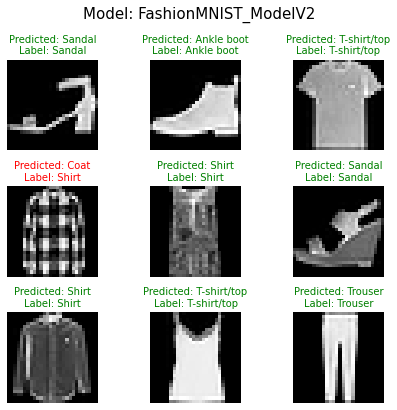

In [ ]:
model_grid(modelv2, 3)

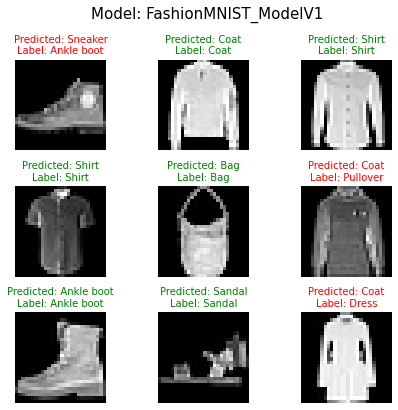

In [ ]:
model_grid(modelv1, 3)

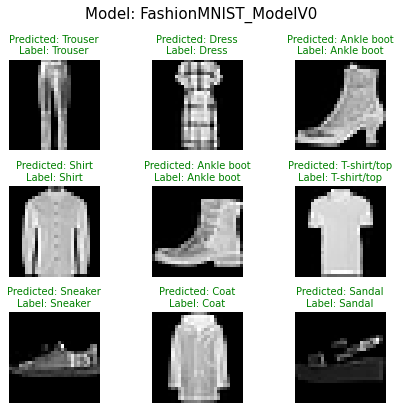

In [ ]:
model_grid(modelv0, 3)

## Confusion Metric

We are going to create a `confusion metrix` to further evaluate our Models.

### Generating Model Predictions to the Entire Test Data Loader

In [ ]:
def predictions(model):
    model.eval()
    with torch.inference_mode():
        y_preds = []

        for x_test, _ in test_dl:
            x_test = x_test.to(device)

            model_logits = model(x_test)
            model_labels = torch.softmax(model_logits, dim=1).argmax(dim=1).cpu() # Moving to cpu for matplotlib

            y_preds.append(model_labels)

    return torch.cat(y_preds) # Converting the list of predictions: tensors into a single tensor

print(len(predictions(modelv2)))

10000


### Setting Confusion Metrix Instance

In [ ]:
confmat = ConfusionMatrix(num_classes=len(name_classes), task="multiclass")

confmat_tesnor = confmat(preds=predictions(modelv2), target=test_dataset.targets)

### Visualize the Confusion Metrix

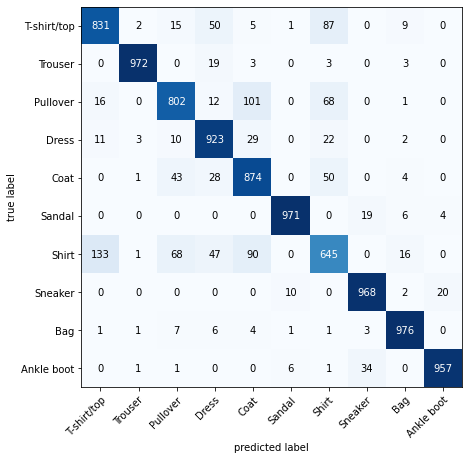

In [ ]:
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tesnor.numpy(), # Needs to be a numpy array
    class_names = name_classes,
    figsize = (10, 7)
    )

The ideal `Confusion Metrix` will be a _diagonal_ matrix.

The value of each number (that should be zero) tell us how many times the model predicted wrong this specific label.